In [48]:
%autosave 30

Autosaving every 30 seconds


In [1]:
%matplotlib inline

import numpy as np
import pickle


#mask
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

#segmentation
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

#classify
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RF

/home/arthur/anaconda2/envs/lung3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:

print("yes")

yes


## Mask Extraction

In [2]:
luna_path = "/data1/cancer/LUNA2016/"
luna_subset_path = luna_path+"subset6/"
output_path = "/data1/cancer/tutorial/"
file_list=glob(luna_subset_path+"*.mhd")

In [3]:
def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))


In [4]:
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

#####
#
# Looping over the image files
#
fcount = 0

for img_file in file_list:
    if( fcount%20) == 1:
        print ("itter: ",fcount," Getting mask for image file %s" % img_file.replace(luna_subset_path,""))

    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:    # some files may not have a nodule--skipping those 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]

        #
        # extracting image
        #
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img) #indexes are z,y,x
        num_z,height,width = img_array.shape        #heightXwidth constitute the transverse plane
        imgs = np.ndarray([3,height,width],dtype=np.uint16)
        masks = np.ndarray([3,height,width],dtype=np.uint8)
        center = np.array([node_x,node_y,node_z])  #nodule center
        origin = np.array(itk_img.GetOrigin()) #x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())# spacing of voxels in world coor. (mm)
        v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space
        #
        # for each slice in the image, convert the image data to the uint16 range
        # and generate a binary mask for the nodule location
        #
        i = 0
        for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
            mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
            masks[i] = mask
            imgs[i] = matrix2int16(img_array[i_z])
            i+=1
        #

        np.save(output_path+"images_%d.npy" % (fcount) ,imgs)
        np.save(output_path+"masks_%d.npy" % (fcount) ,masks)
        fcount+=1

itter:  1  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
itter:  21  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.315187221221054114974341475212.mhd
itter:  41  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
itter:  41  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.mhd
itter:  61  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
itter:  61  Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd


### mask visualization

image 0


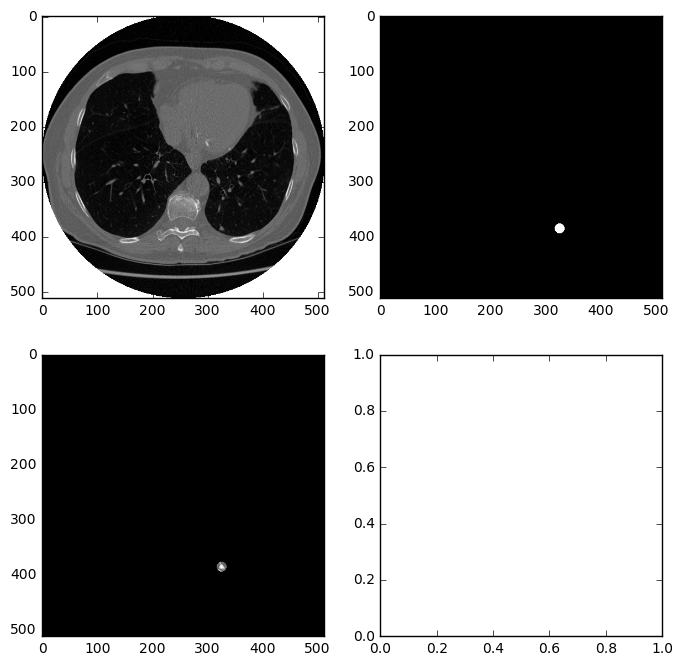

image 1


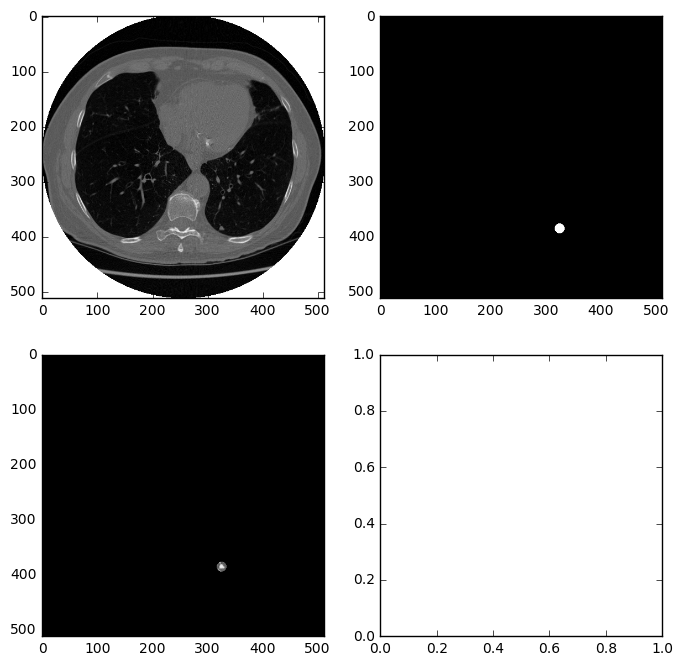

image 2


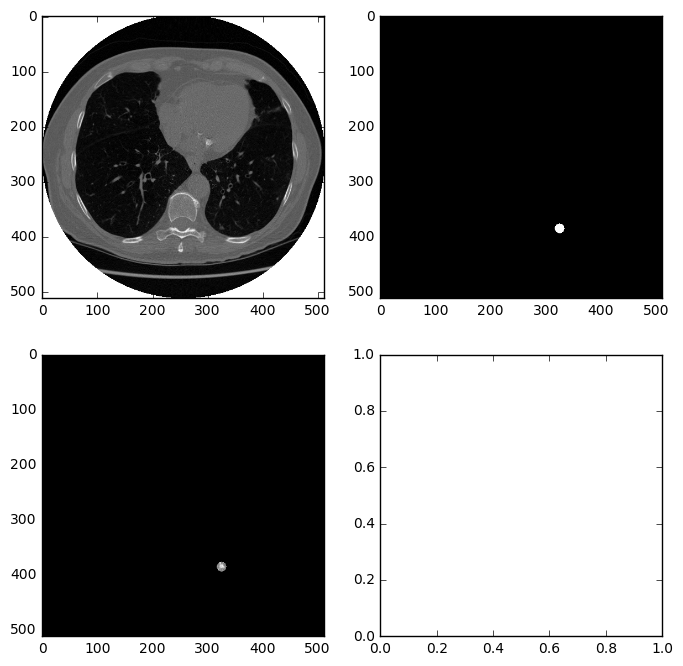

In [5]:
imgs = np.load(output_path+'images_0.npy')
masks = np.load(output_path+'masks_0.npy')

stop = min(len(imgs),4 )
for i in range(0,stop):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()


## segmentation

In [39]:
def cleanImage(img,mask,node_mask): 
    new_size = [512,512]   # we're scaling back up to the original size of the image
    img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
    new_mean = np.mean(img[mask>0])  
    new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
    old_min = np.min(img)       # background color
    img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
    img = img-new_mean
    img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
    labels = measure.label(mask)
    regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
    min_row = 512
    max_row = 0
    min_col = 512
    max_col = 0
    for prop in regions:
        B = prop.bbox
        if min_row > B[0]:
            min_row = B[0]
        if min_col > B[1]:
            min_col = B[1]
        if max_row < B[2]:
            max_row = B[2]
        if max_col < B[3]:
            max_col = B[3]
    width = max_col-min_col
    height = max_row - min_row
    if width > height:
        max_row=min_row+width
    else:
        max_col = min_col+height
    # 
    # cropping the image down to the bounding box for all regions
    # (there's probably an skimage command that can do this in one line)
    # 
    img = img[min_row:max_row,min_col:max_col]
    mask =  mask[min_row:max_row,min_col:max_col]
    if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
        print("bad")
        return[]
    else:
        # moving range to -1 to 1 to accomodate the resize function
        mean = np.mean(img)
        img = img - mean
        min = np.min(img)
        max = np.max(img)
        img = img/(max-min)
        new_img = resize(img,[512,512])
        #new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
        return[new_img]
            
        

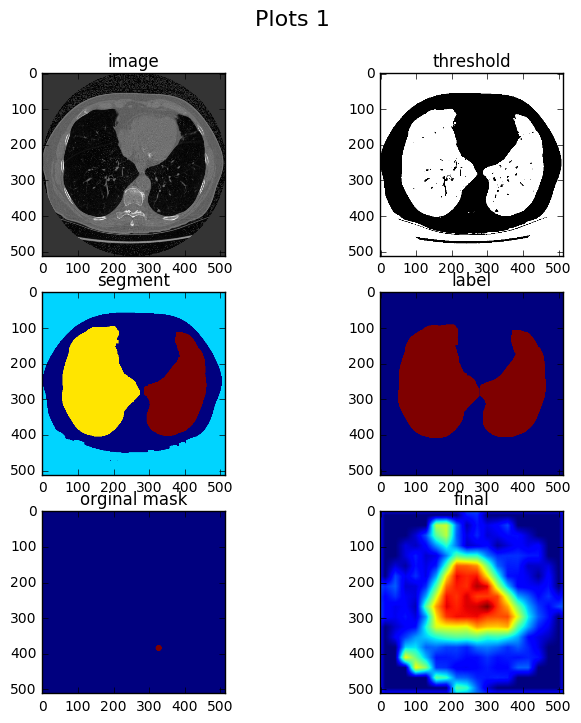

In [47]:
def showImage(index,showwork=True):
    img = imgs[index]
    #fig, ax = plt.subplots(2,2,figsize=[8,8])
    if showwork:
        fig, ((pltImg,pltThresh ),(pltSeg,pltMask),(pltorg,pltFinal)) = plt.subplots(nrows=3, ncols=2,figsize=[8,8])

        fig.suptitle("Plots %d" % index, fontsize=16)

        pltImg.set_title("image")
        pltImg.imshow(img,cmap='gray')

    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean

       #threshold
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    if showwork:
        pltThresh.set_title("threshold")
        pltThresh.imshow(thresh_img,cmap='gray')

        #segment
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    if showwork:
        pltSeg.set_title("segment")
        pltSeg.imshow(labels)

        #regions
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    node_masks = np.ndarray([512,512],dtype=np.int8)
    node_masks[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        node_masks = node_masks + np.where(labels==N,1,0)
        
    node_masks = morphology.dilation(node_masks,np.ones([10,10]))
    if showwork:
        pltMask.set_title("label")
        pltMask.imshow(node_masks) 
        
    mask = masks[i]
    if showwork:
        pltorg.set_title("orginal mask")
        pltorg.imshow(mask)
    
    new_img = cleanImage(img,mask,node_masks)
    if ((len(new_img) > 1) and showwork):
        pltFinal.set_title("final")
        pltFinal.imshow(new_img[0])
    if showwork:
        plt.show()
    return new_img
    
  
thr_img = showImage(1,True)

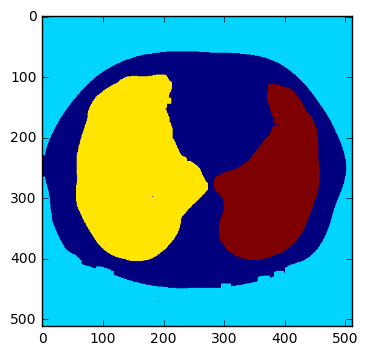